
# 3D adaptive histogram equalization

Adaptive histogram equalization (AHE) can be used to improve the local
contrast of an image [1]_. Specifically, AHE can be useful for normalizing
intensities across images. This example compares the results of applying
global histogram equalization and AHE to a 3D image and a synthetically
degraded version of it.

.. [1] https://en.wikipedia.org/wiki/Histogram_equalization


In [2]:
# from nuclei_segmentation.run_cellpose import load_img
from auxiliary.data.dataset_ht import HtDataset
from auxiliary.data import imaging
from auxiliary.utils.colors import bcolors as c

import numpy as np
from skimage import exposure
from scipy import ndimage
from csbdeep.utils import normalize as deep_norm

In [3]:
ds = HtDataset()
img_path, _ = ds.read_specimen('0208_E2', 'Nuclei', 'RawImages', verbose=1)
img = imaging.read_image(img_path, axes='ZYX', verbose=1)

	Found: 20190208_E2_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190208_E2_DAPI_decon_0.5.nii.gz


In [4]:
print(f'{c.OKBLUE}Equalizing image{c.ENDC}...')

# Rescale image data to range [0, 1]
img = np.clip(img, np.percentile(img, 5), np.percentile(img, 95))
img = (img - img.min()) / (img.max() - img.min())

img = exposure.equalize_hist(img)

vmin, vmax = np.percentile(img, q=(5, 95))
img = exposure.rescale_intensity(img, in_range=(vmin, vmax))

print(f'{c.OKBLUE}Normalizing image{c.ENDC}...')
img = deep_norm(img, 2, 98, axis=(0, 1, 2))

print(f'{c.OKBLUE}Applying Gaussian filter{c.ENDC}...')
img = ndimage.gaussian_filter(img, sigma=1)

print(f'{c.OKBLUE}Applying median filter{c.ENDC}...')
img = ndimage.median_filter(img, size=(3, 3, 3))

imaging.save_nii(img, 'preprocessed.nii.gz', axes='ZYX', verbose=1)

Equalizing image...
Normalizing image...
Applying Gaussian filter...
Applying median filter...

Saving prediction: preprocessed.nii.gz


In [69]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from skimage import exposure, util, restoration
from csbdeep.utils import normalize as deep_norm
from scipy import ndimage

from auxiliary.data import imaging
from auxiliary import values as v

In [64]:
# im_orig = imaging.read_image(
#     v.data_path + 'Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz'
# )

im_orig = imaging.read_image(
    v.data_path + 'Gr4/RawImages/Membrane/20190806_E6_mGFP_decon_0.5.nii.gz'
)

# im_orig = im_orig[120:345, 350:500, 200:250]
im_orig = im_orig[150:550, 150:550, 200:400]
print(im_orig.shape)

img_orig = im_orig / 255

(400, 400, 200)


(-0.5, 399.5, 399.5, -0.5)

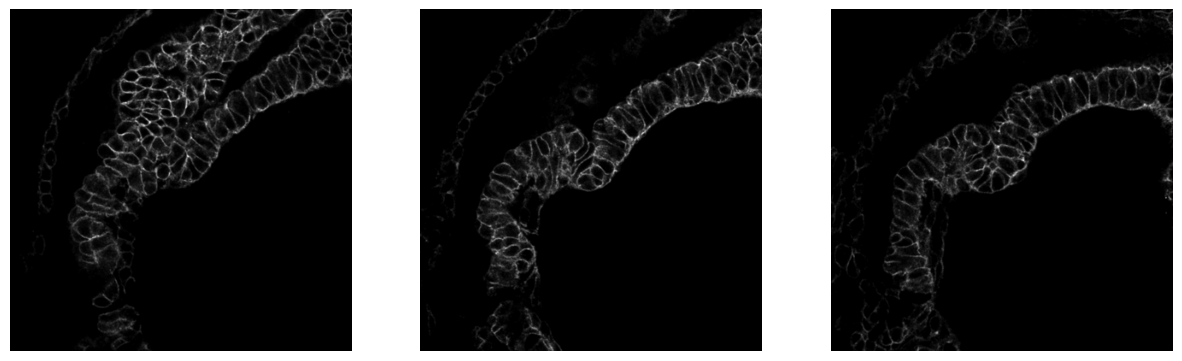

In [65]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(im_orig[..., 0], cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(im_orig[..., 25], cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.imshow(im_orig[..., 49], cmap='gray'); plt.axis('off')

NUCLEI

In [49]:
# # Rescale image data to range [0, 1]
# low, high = np.percentile(im_orig, (5, 95))
# im_orig_he = np.swapaxes(np.swapaxes([
#     exposure.rescale_intensity(im_orig[..., z], in_range=(low, high))
#     # cv2.normalize(im_orig[..., z], None, 0, 1, cv2.NORM_MINMAX)
#     for z in range(im_orig.shape[-1])
# ], 0, 1), 1, 2)
# 
# im_orig_ahe_local = np.swapaxes(np.swapaxes([
#     restoration.denoise_bilateral(im_orig_he[..., z], win_size=7, sigma_color=0.15, sigma_spatial=15)
#     for z in range(im_orig_he.shape[-1])
# ], 0, 1), 1, 2)
# 
# # im_orig_ahe_nonlocal

MEMBRANE

In [73]:
im_orig_he = exposure.equalize_hist(im_orig)
im_orig_ahe_local = deep_norm(im_orig_he, 2, 98, axis=(0, 1, 2))
im_orig_ahe_nonlocal = ndimage.median_filter(im_orig_ahe_local, size=5)

(-0.5, 399.5, 399.5, -0.5)

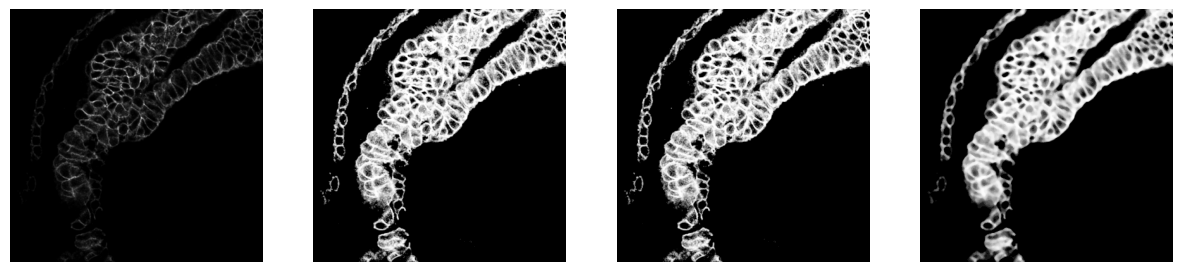

In [74]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.imshow(im_orig[..., 0], cmap='gray'); plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(im_orig_he[..., 0], cmap='gray'); plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(im_orig_ahe_local[..., 0], cmap='gray'); plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(im_orig_ahe_nonlocal[..., 0], cmap='gray'); plt.axis('off')

In [32]:
import napari

viewer = napari.view_image(im_orig)
viewer.add_image(im_orig_he)
viewer.add_image(im_orig_ahe_local)
# viewer.add_image(im_orig_ahe_nonlocal)

<Image layer 'im_orig_ahe_local' at 0x746c3d4c77c0>

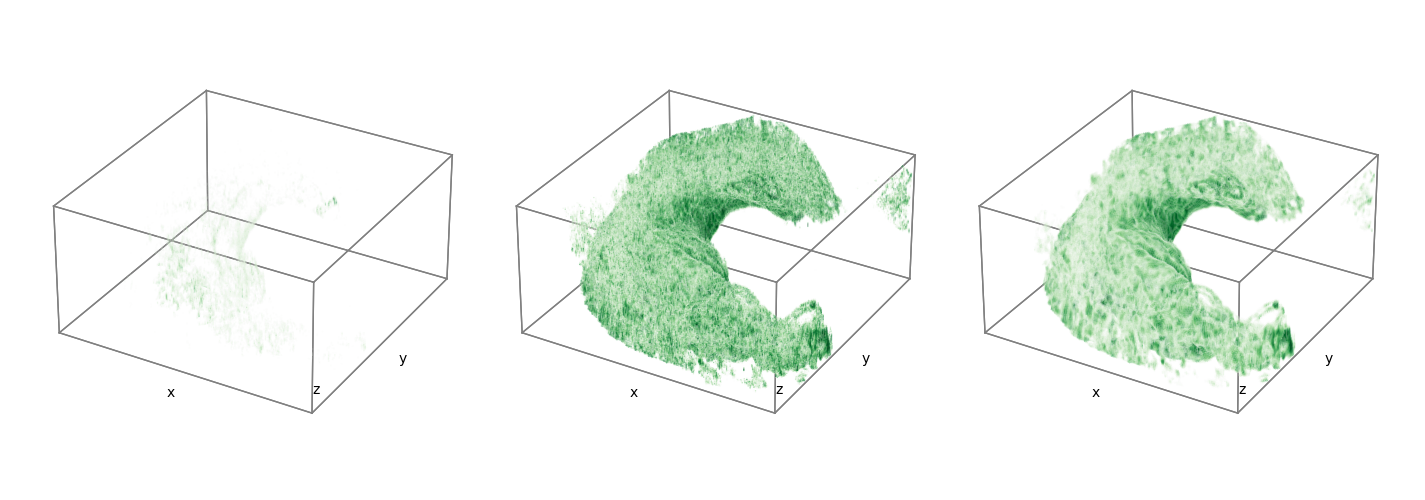

In [77]:
# Define functions to help plot the data
def scalars_to_rgba(scalars, cmap, alpha_scalars=None):
    """
    Convert array of scalars into array of corresponding RGBA values.
    """
    norm = colors.Normalize(vmin=np.min(scalars), vmax=np.max(scalars))
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgbas = scalar_map.to_rgba(scalars)
    if alpha_scalars is not None:
        rgbas[:, 3] = alpha_scalars
    return rgbas


def plt_render_volume(vol, fig_ax, cmap, bin_widths=None):
    """
    Render a volume in a 3D matplotlib scatter plot.
    """
    # Normalize the volume
    vol_scaled = (vol - vol.min()) / (vol.max() - vol.min())
    
    xs, ys, zs = np.mgrid[
        0 : vol.shape[0] : bin_widths[0],
        0 : vol.shape[1] : bin_widths[1],
        0 : vol.shape[2] : bin_widths[2],
    ]
    vol_downsampled = vol_scaled[:: bin_widths[0], :: bin_widths[1], :: bin_widths[2]].flatten()
    xs = xs.flatten()
    ys = ys.flatten()
    zs = zs.flatten()
    
    # Map intensities directly to alpha values
    alphas = vol_downsampled
    
    # Filter out low-intensity voxels for better performance
    threshold = 0.2  # Adjust this threshold as needed
    mask = vol_downsampled > threshold
    xs = xs[mask]
    ys = ys[mask]
    zs = zs[mask]
    vol_downsampled = vol_downsampled[mask]
    alphas = alphas[mask]
    
    # Convert scalars to RGBA
    colors_rgba = scalars_to_rgba(vol_downsampled, cmap, alpha_scalars=alphas)
    
    # Plot the scatter plot
    fig_ax.scatter(
        xs,
        ys,
        zs,
        c=colors_rgba,
        s=0.5 * np.mean(bin_widths),
        marker='o',
        linewidth=0,
    )


# Create figure with subplots
cmap = 'Greens'  # Use a perceptually uniform colormap

fig = plt.figure(figsize=(16, 4))
axs = [fig.add_subplot(1, 3, i + 1, projection='3d', facecolor="none") for i in range(3)]
ims = [im_orig, im_orig_he, im_orig_ahe_nonlocal]  # Replace with your actual images

# Prepare lines for the 3D boxes to be plotted
verts = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]).astype(np.float32)
lines = [
    np.array([i, j])
    for i in verts
    for j in verts
    if np.allclose(np.linalg.norm(i - j), 1)
]

# Render volumetric data
for iax, ax in enumerate(axs):
    plt_render_volume(ims[iax], ax, cmap, bin_widths=[2, 2, 2])
    
    # Plot 3D box
    rect_shape = np.array(ims[iax].shape) + 2
    for line in lines:
        ax.plot(
            (line * rect_shape)[:, 0] - 1,
            (line * rect_shape)[:, 1] - 1,
            (line * rect_shape)[:, 2] - 1,
            linewidth=1,
            color='gray',
        )

# Subplot aesthetics
for ax in axs:
    # Get rid of panes and axis lines
    for dim_ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
        dim_ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
        dim_ax.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Define 3D axes limits
    xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
    XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim * 0.5)

    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        pass

    ax.set_xlabel('x', labelpad=-20)
    ax.set_ylabel('y', labelpad=-20)
    ax.text2D(0.63, 0.2, "z", transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.view_init(elev=30, azim=-60)  # Adjust the view angle if needed

plt.subplots_adjust(
    left=0.05, bottom=-0.1, right=0.95, top=1.1, wspace=-0.1, hspace=-0.45
)

plt.show()

In [60]:
from mayavi import mlab

# Normalize and prepare the data
vol = ims[2]  # Replace with the desired volume
vol_scaled = (vol - vol.min()) / (vol.max() - vol.min())

# Create a Mayavi figure
mlab.figure(size=(800, 600))

# Visualize the volume
src = mlab.pipeline.scalar_field(vol_scaled)
mlab.pipeline.volume(src)

# Show the figure
mlab.show()


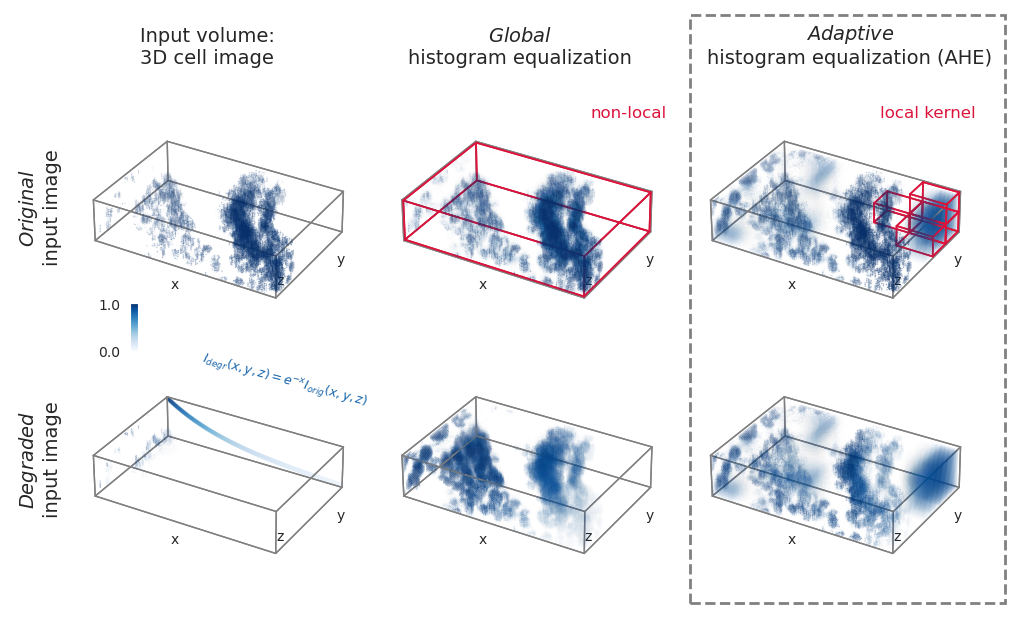

In [117]:

# Define functions to help plot the data
def scalars_to_rgba(scalars, cmap, vmin=0.0, vmax=1.0, alpha=0.2):
    """
    Convert array of scalars into array of corresponding RGBA values.
    """
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgbas = scalar_map.to_rgba(scalars)
    rgbas[:, 3] = alpha
    return rgbas


def plt_render_volume(vol, fig_ax, cmap, vmin=0, vmax=1, bin_widths=None, n_levels=20):
    """
    Render a volume in a 3D matplotlib scatter plot.
    Better would be to use napari.
    """
    vol = np.clip(vol, vmin, vmax)

    xs, ys, zs = np.mgrid[
        0 : vol.shape[0] : bin_widths[0],
        0 : vol.shape[1] : bin_widths[1],
        0 : vol.shape[2] : bin_widths[2],
    ]
    vol_scaled = vol[:: bin_widths[0], :: bin_widths[1], :: bin_widths[2]].flatten()

    # Define alpha transfer function
    levels = np.linspace(vmin, vmax, n_levels)
    alphas = np.linspace(0, 0.7, n_levels)
    alphas = alphas**11
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas *= 0.8

    # Group pixels by intensity and plot separately,
    # as 3D scatter does not accept arrays of alpha values
    for il in range(1, len(levels)):
        sel = vol_scaled >= levels[il - 1]
        sel *= vol_scaled <= levels[il]
        if not np.max(sel):
            continue
        c = scalars_to_rgba(
            vol_scaled[sel], cmap, vmin=vmin, vmax=vmax, alpha=alphas[il - 1]
        )
        fig_ax.scatter(
            xs.flatten()[sel],
            ys.flatten()[sel],
            zs.flatten()[sel],
            c=c,
            s=0.5 * np.mean(bin_widths),
            marker='o',
            linewidth=0,
        )


# Create figure with subplots

cmap = 'Blues'

fig = plt.figure(figsize=(10, 6))
axs = [
    fig.add_subplot(2, 3, i + 1, projection=Axes3D.name, facecolor="none")
    for i in range(6)
]
ims = [im_orig, im_orig_he, im_orig_ahe, im_degraded, im_degraded_he, im_degraded_ahe]

# Prepare lines for the various boxes to be plotted
verts = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]).astype(
    np.float32
)
lines = [
    np.array([i, j])
    for i in verts
    for j in verts
    if np.allclose(np.linalg.norm(i - j), 1)
]

# "render" volumetric data
for iax, ax in enumerate(axs[:]):
    plt_render_volume(ims[iax], ax, cmap, 0, 1, [2, 2, 2], 20)

    # plot 3D box
    rect_shape = np.array(im_orig.shape) + 2
    for line in lines:
        ax.plot(
            (line * rect_shape)[:, 0] - 1,
            (line * rect_shape)[:, 1] - 1,
            (line * rect_shape)[:, 2] - 1,
            linewidth=1,
            color='gray',
        )

# Add boxes illustrating the kernels
ns = np.array(im_orig.shape) // kernel_size - 1
for axis_ind, vertex_ind, box_shape in zip(
    [1] + [2] * 4,
    [
        [0, 0, 0],
        [ns[0] - 1, ns[1], ns[2] - 1],
        [ns[0], ns[1] - 1, ns[2] - 1],
        [ns[0], ns[1], ns[2] - 1],
        [ns[0], ns[1], ns[2]],
    ],
    [np.array(im_orig.shape)] + [kernel_size] * 4,
):
    for line in lines:
        axs[axis_ind].plot(
            ((line + vertex_ind) * box_shape)[:, 0],
            ((line + vertex_ind) * box_shape)[:, 1],
            ((line + vertex_ind) * box_shape)[:, 2],
            linewidth=1.2,
            color='crimson',
        )

# Plot degradation function
axs[3].scatter(
    xs=np.arange(len(sigmoid)),
    ys=np.zeros(len(sigmoid)) + im_orig.shape[1],
    zs=sigmoid * im_orig.shape[2],
    s=5,
    c=scalars_to_rgba(sigmoid, cmap=cmap, vmin=0, vmax=1, alpha=1.0)[:, :3],
)

# Subplot aesthetics
for iax, ax in enumerate(axs[:]):
    # Get rid of panes and axis lines
    for dim_ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
        dim_ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
        dim_ax.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Define 3D axes limits, see https://github.com/
    # matplotlib/matplotlib/issues/17172#issuecomment-617546105
    xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
    XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim * 0.5)

    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        pass

    ax.set_xlabel('x', labelpad=-20)
    ax.set_ylabel('y', labelpad=-20)
    ax.text2D(0.63, 0.2, "z", transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.elev = 30

plt.subplots_adjust(
    left=0.05, bottom=-0.1, right=1.01, top=1.1, wspace=-0.1, hspace=-0.45
)

# Highlight AHE
rect_ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
rect_ax.set_axis_off()
rect = patches.Rectangle(
    (0.68, 0.01),
    0.315,
    0.98,
    edgecolor='gray',
    facecolor='none',
    linewidth=2,
    linestyle='--',
)
rect_ax.add_patch(rect)

# Add text
rect_ax.text(
    0.19,
    0.34,
    '$I_{degr}(x,y,z) = e^{-x}I_{orig}(x,y,z)$',
    fontsize=9,
    rotation=-15,
    color=scalars_to_rgba([0.8], cmap='Blues', alpha=1.0)[0],
)

fc = {'size': 14}
rect_ax.text(
    0.03,
    0.58,
    r'$\it{Original}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.03,
    0.16,
    r'$\it{Degraded}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(0.13, 0.91, 'Input volume:\n3D cell image', fontdict=fc)
rect_ax.text(
    0.51,
    0.91,
    r'$\it{Global}$' + '\nhistogram equalization',
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.84,
    0.91,
    r'$\it{Adaptive}$' + '\nhistogram equalization (AHE)',
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(0.58, 0.82, 'non-local', fontsize=12, color='crimson')
rect_ax.text(0.87, 0.82, 'local kernel', fontsize=12, color='crimson')

# Add colorbar
cbar_ax = fig.add_axes([0.12, 0.43, 0.008, 0.08])
cbar_ax.imshow(np.arange(256).reshape(256, 1)[::-1], cmap=cmap, aspect="auto")
cbar_ax.set_xticks([])
cbar_ax.set_yticks([0, 255])
cbar_ax.set_xticklabels([])
cbar_ax.set_yticklabels([1.0, 0.0])

plt.show()

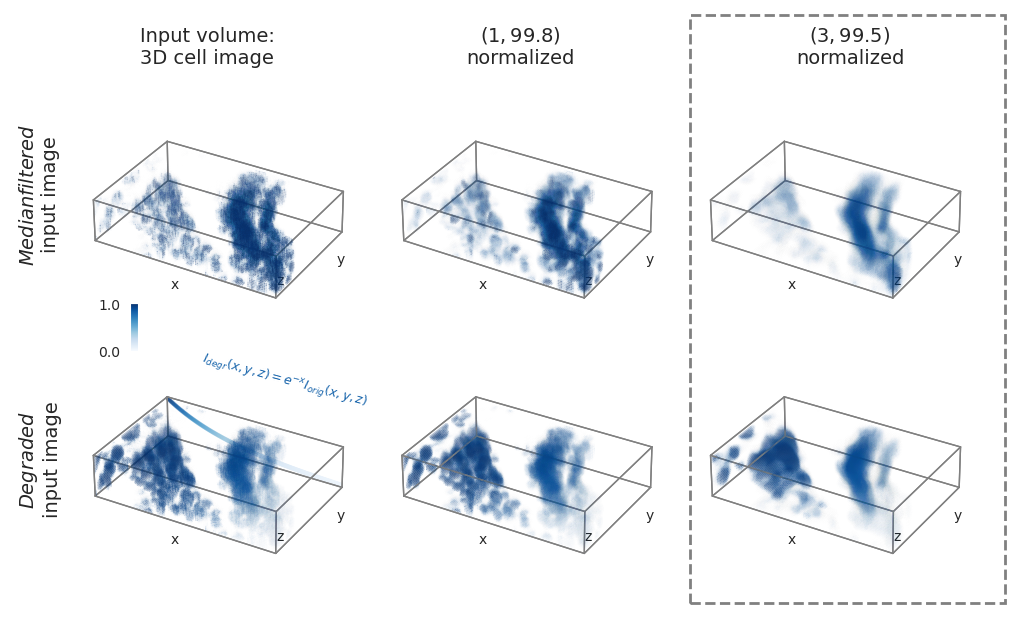

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from skimage import exposure, util

from auxiliary.data import imaging
from auxiliary import values as v

from scipy import ndimage
from csbdeep.utils import normalize as deep_norm

im_orig = im_orig_he
im_degraded = im_degraded_he

# Perform histogram equalization
im_orig_he, im_degraded_he = (
    ndimage.median_filter(im, size=(5, 5, 5)) for im in [im_orig, im_degraded]
)

im_orig_ahe, im_degraded_ahe = (
    ndimage.median_filter(im, size=(15, 15, 15))
    for im in [im_orig, im_degraded]
)


# Define functions to help plot the data


def scalars_to_rgba(scalars, cmap, vmin=0.0, vmax=1.0, alpha=0.2):
    """
    Convert array of scalars into array of corresponding RGBA values.
    """
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgbas = scalar_map.to_rgba(scalars)
    rgbas[:, 3] = alpha
    return rgbas


def plt_render_volume(vol, fig_ax, cmap, vmin=0, vmax=1, bin_widths=None, n_levels=20):
    """
    Render a volume in a 3D matplotlib scatter plot.
    Better would be to use napari.
    """
    vol = np.clip(vol, vmin, vmax)

    xs, ys, zs = np.mgrid[
        0 : vol.shape[0] : bin_widths[0],
        0 : vol.shape[1] : bin_widths[1],
        0 : vol.shape[2] : bin_widths[2],
    ]
    vol_scaled = vol[:: bin_widths[0], :: bin_widths[1], :: bin_widths[2]].flatten()

    # Define alpha transfer function
    levels = np.linspace(vmin, vmax, n_levels)
    alphas = np.linspace(0, 0.7, n_levels)
    alphas = alphas**11
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas *= 0.8

    # Group pixels by intensity and plot separately,
    # as 3D scatter does not accept arrays of alpha values
    for il in range(1, len(levels)):
        sel = vol_scaled >= levels[il - 1]
        sel *= vol_scaled <= levels[il]
        if not np.max(sel):
            continue
        c = scalars_to_rgba(
            vol_scaled[sel], cmap, vmin=vmin, vmax=vmax, alpha=alphas[il - 1]
        )
        fig_ax.scatter(
            xs.flatten()[sel],
            ys.flatten()[sel],
            zs.flatten()[sel],
            c=c,
            s=0.5 * np.mean(bin_widths),
            marker='o',
            linewidth=0,
        )


# Create figure with subplots

cmap = 'Blues'

fig = plt.figure(figsize=(10, 6))
axs = [
    fig.add_subplot(2, 3, i + 1, projection=Axes3D.name, facecolor="none")
    for i in range(6)
]
ims = [im_orig, im_orig_he, im_orig_ahe, im_degraded, im_degraded_he, im_degraded_ahe]

# Prepare lines for the various boxes to be plotted
verts = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]).astype(
    np.float32
)
lines = [
    np.array([i, j])
    for i in verts
    for j in verts
    if np.allclose(np.linalg.norm(i - j), 1)
]

# "render" volumetric data
for iax, ax in enumerate(axs[:]):
    plt_render_volume(ims[iax], ax, cmap, 0, 1, [2, 2, 2], 20)

    # plot 3D box
    rect_shape = np.array(im_orig.shape) + 2
    for line in lines:
        ax.plot(
            (line * rect_shape)[:, 0] - 1,
            (line * rect_shape)[:, 1] - 1,
            (line * rect_shape)[:, 2] - 1,
            linewidth=1,
            color='gray',
        )

# Add boxes illustrating the kernels
# ns = np.array(im_orig.shape) // kernel_size - 1
# for axis_ind, vertex_ind, box_shape in zip(
#     [1] + [2] * 4,
#     [
#         [0, 0, 0],
#         [ns[0] - 1, ns[1], ns[2] - 1],
#         [ns[0], ns[1] - 1, ns[2] - 1],
#         [ns[0], ns[1], ns[2] - 1],
#         [ns[0], ns[1], ns[2]],
#     ],
#     [np.array(im_orig.shape)] + [kernel_size] * 4,
# ):
#     for line in lines:
#         axs[axis_ind].plot(
#             ((line + vertex_ind) * box_shape)[:, 0],
#             ((line + vertex_ind) * box_shape)[:, 1],
#             ((line + vertex_ind) * box_shape)[:, 2],
#             linewidth=1.2,
#             color='crimson',
#         )

# Plot degradation function
axs[3].scatter(
    xs=np.arange(len(sigmoid)),
    ys=np.zeros(len(sigmoid)) + im_orig.shape[1],
    zs=sigmoid * im_orig.shape[2],
    s=5,
    c=scalars_to_rgba(sigmoid, cmap=cmap, vmin=0, vmax=1, alpha=1.0)[:, :3],
)

# Subplot aesthetics
for iax, ax in enumerate(axs[:]):
    # Get rid of panes and axis lines
    for dim_ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
        dim_ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
        dim_ax.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Define 3D axes limits, see https://github.com/
    # matplotlib/matplotlib/issues/17172#issuecomment-617546105
    xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
    XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim * 0.5)

    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        pass

    ax.set_xlabel('x', labelpad=-20)
    ax.set_ylabel('y', labelpad=-20)
    ax.text2D(0.63, 0.2, "z", transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.elev = 30

plt.subplots_adjust(
    left=0.05, bottom=-0.1, right=1.01, top=1.1, wspace=-0.1, hspace=-0.45
)

# Highlight AHE
rect_ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
rect_ax.set_axis_off()
rect = patches.Rectangle(
    (0.68, 0.01),
    0.315,
    0.98,
    edgecolor='gray',
    facecolor='none',
    linewidth=2,
    linestyle='--',
)
rect_ax.add_patch(rect)

# Add text
rect_ax.text(
    0.19,
    0.34,
    '$I_{degr}(x,y,z) = e^{-x}I_{orig}(x,y,z)$',
    fontsize=9,
    rotation=-15,
    color=scalars_to_rgba([0.8], cmap='Blues', alpha=1.0)[0],
)

fc = {'size': 14}
rect_ax.text(
    0.03,
    0.58,
    r'$\it{Equalized}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.03,
    0.16,
    r'$\it{Degraded}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(0.13, 0.91, 'Input volume:\n3D cell image', fontdict=fc)
rect_ax.text(
    0.51,
    0.91,
    r'$\it{(1, 99.8)}$' + '\nnormalized',
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.84,
    0.91,
    r'$\it{(3, 99.5)}$' + '\nnormalized',
    fontdict=fc,
    horizontalalignment='center',
)
# rect_ax.text(0.58, 0.82, 'non-local', fontsize=12, color='crimson')
# rect_ax.text(0.87, 0.82, 'local kernel', fontsize=12, color='crimson')

# Add colorbar
cbar_ax = fig.add_axes([0.12, 0.43, 0.008, 0.08])
cbar_ax.imshow(np.arange(256).reshape(256, 1)[::-1], cmap=cmap, aspect="auto")
cbar_ax.set_xticks([])
cbar_ax.set_yticks([0, 255])
cbar_ax.set_xticklabels([])
cbar_ax.set_yticklabels([1.0, 0.0])

plt.show()

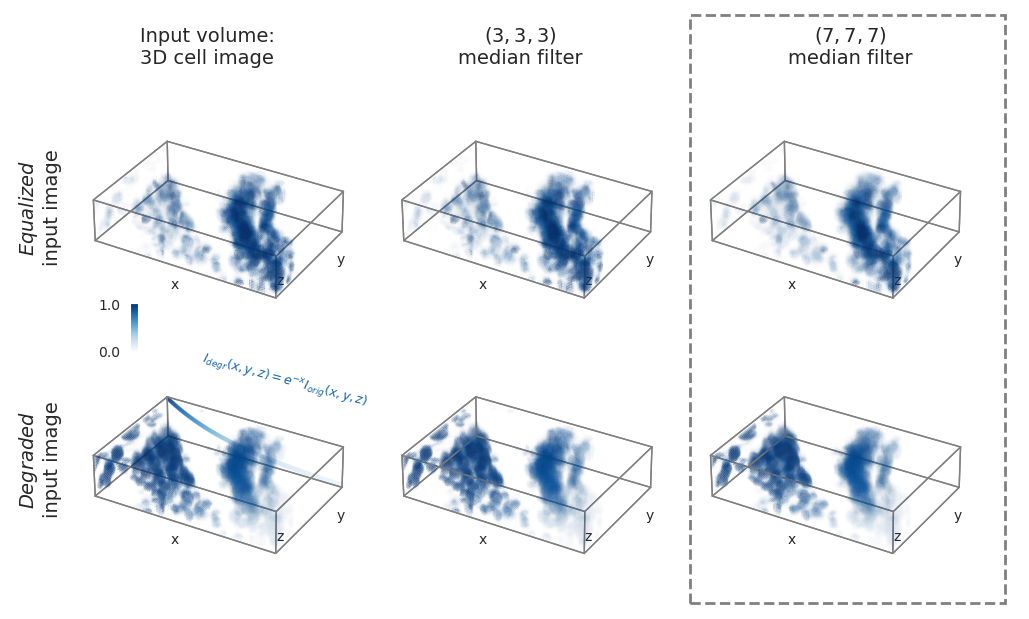

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from skimage import exposure, util

from auxiliary.data import imaging
from auxiliary import values as v

from scipy import ndimage
from csbdeep.utils import normalize as deep_norm

im_orig = im_orig_he
im_degraded = im_degraded_he

# Perform histogram equalization
im_orig_he, im_degraded_he = (
    ndimage.median_filter(im, size=(3, 3, 3)) for im in [im_orig, im_degraded]
)

im_orig_ahe, im_degraded_ahe = (
    ndimage.median_filter(im, size=(7, 7, 7))
    for im in [im_orig, im_degraded]
)


# Define functions to help plot the data


def scalars_to_rgba(scalars, cmap, vmin=0.0, vmax=1.0, alpha=0.2):
    """
    Convert array of scalars into array of corresponding RGBA values.
    """
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgbas = scalar_map.to_rgba(scalars)
    rgbas[:, 3] = alpha
    return rgbas


def plt_render_volume(vol, fig_ax, cmap, vmin=0, vmax=1, bin_widths=None, n_levels=20):
    """
    Render a volume in a 3D matplotlib scatter plot.
    Better would be to use napari.
    """
    vol = np.clip(vol, vmin, vmax)

    xs, ys, zs = np.mgrid[
        0 : vol.shape[0] : bin_widths[0],
        0 : vol.shape[1] : bin_widths[1],
        0 : vol.shape[2] : bin_widths[2],
    ]
    vol_scaled = vol[:: bin_widths[0], :: bin_widths[1], :: bin_widths[2]].flatten()

    # Define alpha transfer function
    levels = np.linspace(vmin, vmax, n_levels)
    alphas = np.linspace(0, 0.7, n_levels)
    alphas = alphas**11
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas *= 0.8

    # Group pixels by intensity and plot separately,
    # as 3D scatter does not accept arrays of alpha values
    for il in range(1, len(levels)):
        sel = vol_scaled >= levels[il - 1]
        sel *= vol_scaled <= levels[il]
        if not np.max(sel):
            continue
        c = scalars_to_rgba(
            vol_scaled[sel], cmap, vmin=vmin, vmax=vmax, alpha=alphas[il - 1]
        )
        fig_ax.scatter(
            xs.flatten()[sel],
            ys.flatten()[sel],
            zs.flatten()[sel],
            c=c,
            s=0.5 * np.mean(bin_widths),
            marker='o',
            linewidth=0,
        )


# Create figure with subplots

cmap = 'Blues'

fig = plt.figure(figsize=(10, 6))
axs = [
    fig.add_subplot(2, 3, i + 1, projection=Axes3D.name, facecolor="none")
    for i in range(6)
]
ims = [im_orig, im_orig_he, im_orig_ahe, im_degraded, im_degraded_he, im_degraded_ahe]

# Prepare lines for the various boxes to be plotted
verts = np.array([[i, j, k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]).astype(
    np.float32
)
lines = [
    np.array([i, j])
    for i in verts
    for j in verts
    if np.allclose(np.linalg.norm(i - j), 1)
]

# "render" volumetric data
for iax, ax in enumerate(axs[:]):
    plt_render_volume(ims[iax], ax, cmap, 0, 1, [2, 2, 2], 20)

    # plot 3D box
    rect_shape = np.array(im_orig.shape) + 2
    for line in lines:
        ax.plot(
            (line * rect_shape)[:, 0] - 1,
            (line * rect_shape)[:, 1] - 1,
            (line * rect_shape)[:, 2] - 1,
            linewidth=1,
            color='gray',
        )

# Add boxes illustrating the kernels
# ns = np.array(im_orig.shape) // kernel_size - 1
# for axis_ind, vertex_ind, box_shape in zip(
#     [1] + [2] * 4,
#     [
#         [0, 0, 0],
#         [ns[0] - 1, ns[1], ns[2] - 1],
#         [ns[0], ns[1] - 1, ns[2] - 1],
#         [ns[0], ns[1], ns[2] - 1],
#         [ns[0], ns[1], ns[2]],
#     ],
#     [np.array(im_orig.shape)] + [kernel_size] * 4,
# ):
#     for line in lines:
#         axs[axis_ind].plot(
#             ((line + vertex_ind) * box_shape)[:, 0],
#             ((line + vertex_ind) * box_shape)[:, 1],
#             ((line + vertex_ind) * box_shape)[:, 2],
#             linewidth=1.2,
#             color='crimson',
#         )

# Plot degradation function
axs[3].scatter(
    xs=np.arange(len(sigmoid)),
    ys=np.zeros(len(sigmoid)) + im_orig.shape[1],
    zs=sigmoid * im_orig.shape[2],
    s=5,
    c=scalars_to_rgba(sigmoid, cmap=cmap, vmin=0, vmax=1, alpha=1.0)[:, :3],
)

# Subplot aesthetics
for iax, ax in enumerate(axs[:]):
    # Get rid of panes and axis lines
    for dim_ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
        dim_ax.set_pane_color((1.0, 1.0, 1.0, 0.0))
        dim_ax.line.set_color((1.0, 1.0, 1.0, 0.0))

    # Define 3D axes limits, see https://github.com/
    # matplotlib/matplotlib/issues/17172#issuecomment-617546105
    xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
    XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim * 0.5)

    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        pass

    ax.set_xlabel('x', labelpad=-20)
    ax.set_ylabel('y', labelpad=-20)
    ax.text2D(0.63, 0.2, "z", transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.elev = 30

plt.subplots_adjust(
    left=0.05, bottom=-0.1, right=1.01, top=1.1, wspace=-0.1, hspace=-0.45
)

# Highlight AHE
rect_ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
rect_ax.set_axis_off()
rect = patches.Rectangle(
    (0.68, 0.01),
    0.315,
    0.98,
    edgecolor='gray',
    facecolor='none',
    linewidth=2,
    linestyle='--',
)
rect_ax.add_patch(rect)

# Add text
rect_ax.text(
    0.19,
    0.34,
    '$I_{degr}(x,y,z) = e^{-x}I_{orig}(x,y,z)$',
    fontsize=9,
    rotation=-15,
    color=scalars_to_rgba([0.8], cmap='Blues', alpha=1.0)[0],
)

fc = {'size': 14}
rect_ax.text(
    0.03,
    0.58,
    r'$\it{Normalized}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.03,
    0.16,
    r'$\it{Degraded}$' + '\ninput image',
    rotation=90,
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(0.13, 0.91, 'Input volume:\n3D cell image', fontdict=fc)
rect_ax.text(
    0.51,
    0.91,
    r'$\it{(3, 3, 3)}$' + '\nmedian filter',
    fontdict=fc,
    horizontalalignment='center',
)
rect_ax.text(
    0.84,
    0.91,
    r'$\it{(7, 7, 7)}$' + '\nmedian filter',
    fontdict=fc,
    horizontalalignment='center',
)
# rect_ax.text(0.58, 0.82, 'non-local', fontsize=12, color='crimson')
# rect_ax.text(0.87, 0.82, 'local kernel', fontsize=12, color='crimson')

# Add colorbar
cbar_ax = fig.add_axes([0.12, 0.43, 0.008, 0.08])
cbar_ax.imshow(np.arange(256).reshape(256, 1)[::-1], cmap=cmap, aspect="auto")
cbar_ax.set_xticks([])
cbar_ax.set_yticks([0, 255])
cbar_ax.set_xticklabels([])
cbar_ax.set_yticklabels([1.0, 0.0])

plt.show()

In [132]:
import sys
from auxiliary.utils.colors import bcolors as c
import cv2


def load_img(img, degrade=False, equalize_img=True, normalize_img=True, verbose=0):
    """
    Load and normalize image.
    :param img_path: Path to image.
    :param normalize_img: Normalize image. (Default: True)
    :param equalize_img: Perform histogram equalization on image. (Default: True)
    :param verbose: Verbosity level.
    :return: Image.
    """
    
    img = img[100:380, 270:540, 200:500]
    imaging.save_nii(img, img_path.replace('.nii.gz', '_crop.nii.gz'), verbose=verbose)
    if verbose:
        print(f'{c.OKBLUE}Loaded image{c.ENDC}: {img_path}')
        print(f'{c.BOLD}Image shape{c.ENDC}: {img.shape}')

    # Degrade image by applying exponential intensity decay along x
    if degrade:
        sigmoid = np.exp(-3 * np.linspace(0, 1, img.shape[0]))
        img = (img.T * sigmoid).T

    if verbose:
        print(f'{c.OKBLUE}Equalizing image{c.ENDC}...')

    # # Rescale image data to range [0, 1]
    img = np.clip(img, np.percentile(img, 5), np.percentile(img, 95))
    img = (img - img.min()) / (img.max() - img.min())

    img = exposure.equalize_hist(img)
    
    vmin, vmax = np.percentile(img, q=(5, 95))
    img = exposure.rescale_intensity(img, in_range=(vmin, vmax))
    
    # # # Determine kernel sizes in each dim relative to image shape
    # # kernel_size = (img.shape[0] // 5, img.shape[1] // 5, img.shape[2] // 2)
    # # kernel_size = np.array(kernel_size)
    # # img = exposure.equalize_adapthist(img, clip_limit=0.9, kernel_size=kernel_size)
    # 
    imaging.save_nii(img, img_path.replace('.nii.gz', '_equalized.nii.gz'), verbose=verbose)
    
    if verbose:
        print(f'{c.OKBLUE}Normalizing image{c.ENDC}...')

    img = deep_norm(img, 5, 95, axis=(0, 1, 2))

    imaging.save_nii(img, img_path.replace('.nii.gz', '_normalized.nii.gz'), verbose=verbose)

    # Median filter
    if verbose:
        print(f'{c.OKBLUE}Applying median filter{c.ENDC}...')

    img = ndimage.median_filter(img, size=(3, 3, 3))
    img = ndimage.median_filter(img, size=(3, 3, 3))

    imaging.save_nii(img, img_path.replace('.nii.gz', '_m_filtered.nii.gz'), verbose=verbose)
    return img


- NO Global eq
- Norm 2 - 99.5 (XY)
- Median 3

In [134]:
img_path = v.data_path + 'Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz'
img = img = imaging.read_image(img_path, axes='XYZ', verbose=1)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz


In [135]:
img_new = load_img(img, degrade=False, verbose=1)


Saving prediction: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5_crop.nii.gz
Loaded image: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5.nii.gz
Image shape: (280, 270, 300)
Equalizing image...

Saving prediction: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5_equalized.nii.gz
Normalizing image...

Saving prediction: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5_normalized.nii.gz
Applying median filter...

Saving prediction: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr4/RawImages/Nuclei/20190806_E6_DAPI_decon_0.5_m_filtered.nii.gz
